In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageColor
from PIL import ImageFont
from PIL import ImageDraw
from PIL import ImageOps
import numpy as np
import random

In [2]:
random_path = "F:/BE_Practicals_sem_VII/images"

In [3]:
def display_image(img, img_file):
    plt.figure(figsize=(15,10))
    plt.imshow(img)
    plt.title(img_file)
    plt.grid(False)
    
def resize_image(img, new_width=300, new_height=300,display=False):
    img_path = os.path.join(random_path,img)
    pil_image = Image.open(img_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    if display:
        display_image(pil_image, img)

C:\Users\Praj\AppData\Local\Temp\ipykernel_2588\3009506501.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


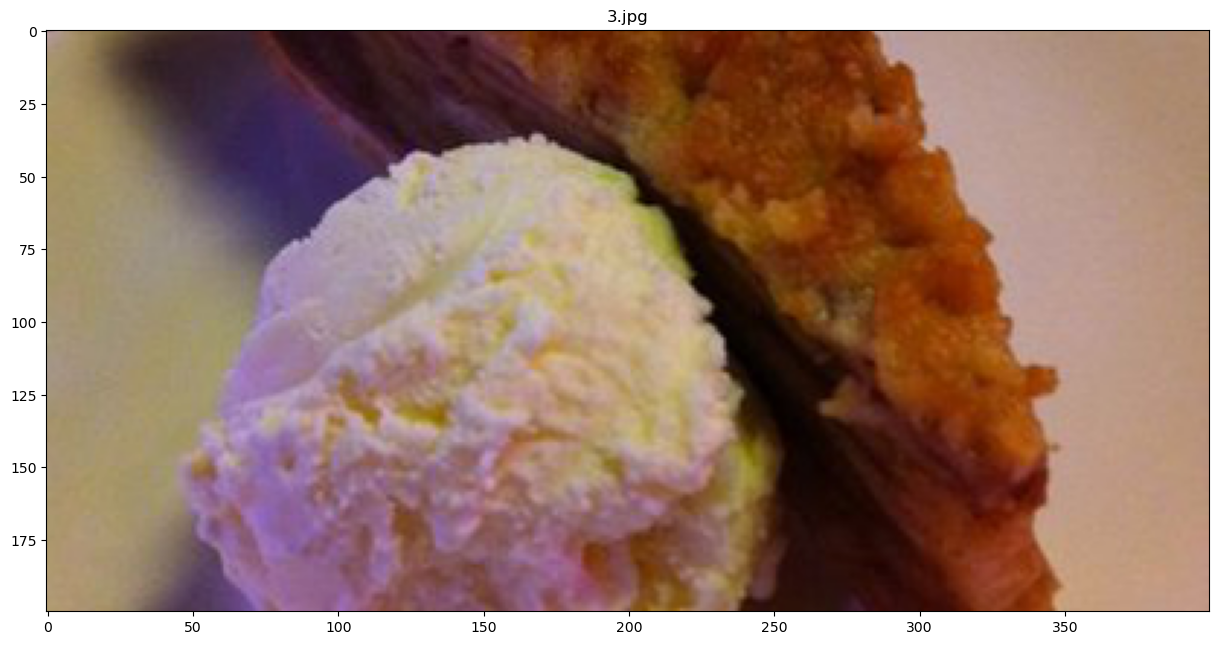

In [4]:
# Applying the Function 
resize_image(random.choice(os.listdir(random_path)),400,200,True)

In [5]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, font, color, thickness=4, display_str_list=()):
    draw = ImageDraw.Draw(image)
    im_w, im_h = image.size
    (left,right,top,bottom)=(xmin*im_w, xmax*im_w, ymin*im_h, ymax*im_h)
    draw.line([(left,top), (left,bottom), (right,bottom), (right,top), (left,top)], width = thickness, fill = color)
    
    display_height_str = [font.getsize(ds)[1] for ds in display_str_list]
    total_height = (1+2*0.05)*sum(display_height_str)
    
    if top > total_height:
        text_bottom = top
    else:
        text_bottom = top+total_height
        
    for display_str in display_str_list[::-1]:
        text_w, text_h = font.getsize(display_str)
        margin = np.ceil(0.05*text_h)
        draw.rectangle([(left,text_bottom-text_h-2*margin),(left+text_w,text_bottom)], fill = color)
        draw.text((left+margin, text_bottom-text_h-margin), display_str, fill="black", font=font)
        text_bottom -= text_h-2*margin

In [6]:
def draw_boxes(image, boxes, class_names, scores, max_box = 3, min_score = 0.1):
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()
    
    for i in range(min(boxes.shape[0], max_box)):
        if scores[i] >= min_score:
            color = colors[hash(class_names[i]) % len(colors)]
            display_str = "{} : {}%".format(class_names[i].decode("ascii"),int(100*scores[i]))
            ymin,xmin,ymax,xmax = tuple(boxes[i])
            pil_image = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(pil_image,ymin,xmin,ymax,xmax,font,color,display_str_list = [display_str])
            np.copyto(image,np.array(pil_image))
            
    return image

In [7]:
def load_image(img_file):
    path = os.path.join(random_path,img_file)
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

In [8]:
def detect(model,img_file):
    image = load_image(img_file)
    converted_img = tf.image.convert_image_dtype(image,tf.float32)[tf.newaxis, ...]
    result = model(converted_img)
    result = {key: value.numpy() for key,value in result.items()}
    
    images_with_boxes = draw_boxes(image.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])
    
    display_image(images_with_boxes, img_file)

In [9]:
model_path = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
pretrained_model = hub.load(model_path).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


C:\Users\Praj\AppData\Local\Temp\ipykernel_2588\4115697143.py:7: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_height_str = [font.getsize(ds)[1] for ds in display_str_list]
C:\Users\Praj\AppData\Local\Temp\ipykernel_2588\4115697143.py:16: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_w, text_h = font.getsize(display_str)


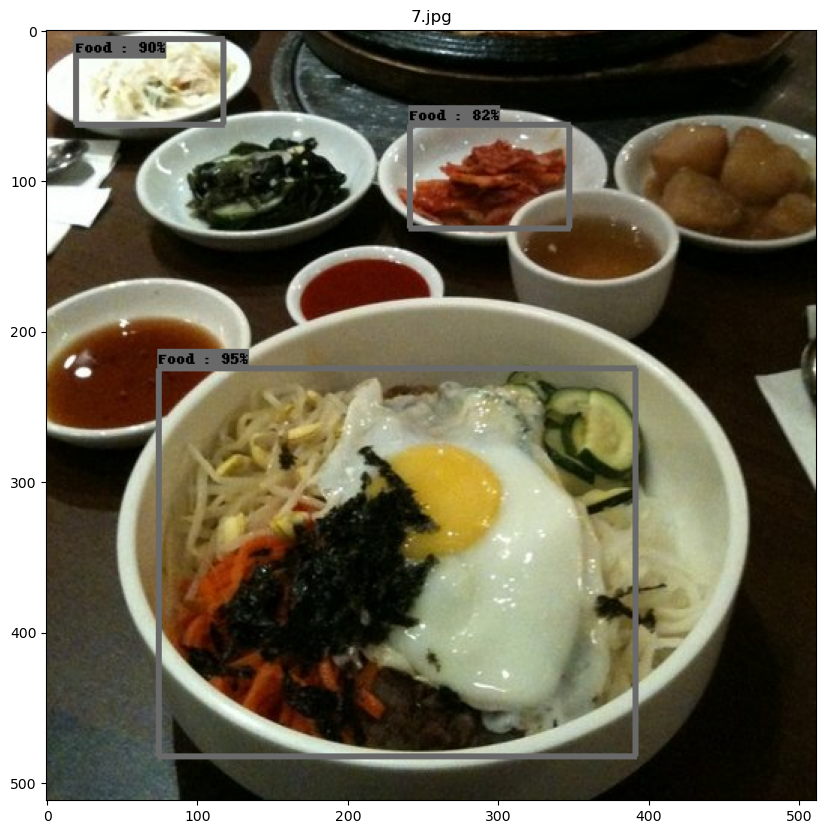

In [11]:
import random

detect(pretrained_model, random.choice(os.listdir(random_path)))